In [4]:
import tensorflow as tf

# You'll generate plots of attention in order to see which parts of an image
# your model focuses on during captioning
import matplotlib.pyplot as plt

import collections
import random
import numpy as np
import os
import time
import json
from PIL import Image

In [7]:
# Download caption annotation files
annotation_folder = '/annotations/'
if not os.path.exists(os.path.abspath('.') + annotation_folder):
  annotation_zip = tf.keras.utils.get_file('captions.zip',
                                           cache_subdir=os.path.abspath('.'),
                                           origin='http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
                                           extract=True)
  annotation_file = os.path.dirname(annotation_zip)+'/annotations/captions_train2014.json'
  os.remove(annotation_zip)

# Download image files
image_folder = '/train2014/'
if not os.path.exists(os.path.abspath('.') + image_folder):
  image_zip = tf.keras.utils.get_file('train2014.zip',
                                      cache_subdir=os.path.abspath('.'),
                                      origin='http://images.cocodataset.org/zips/train2014.zip',
                                      extract=True)
  PATH = os.path.dirname(image_zip) + image_folder
  os.remove(image_zip)
else:
  PATH = os.path.abspath('.') + image_folder
annotation_file = os.path.dirname(annotation_zip)+'/annotations/captions_train2014.json'

NameError: name 'annotation_zip' is not defined

In [8]:
annotation_file = './annotations/captions_train2014.json'
with open(annotation_file, 'r') as f:
    annotations = json.load(f)


In [9]:
# Group all captions together having the same image ID.
image_path_to_caption = collections.defaultdict(list)
for val in annotations['annotations']:
  caption = f"<start> {val['caption']} <end>"
  image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (val['image_id'])
  image_path_to_caption[image_path].append(caption)

In [10]:
image_paths = list(image_path_to_caption.keys())
random.shuffle(image_paths)

# Select the first 6000 image_paths from the shuffled set.
# Approximately each image id has 5 captions associated with it, so that will
# lead to 30,000 examples.
train_image_paths = image_paths[:6000]
print(len(train_image_paths))


6000


In [11]:
train_captions = []
img_name_vector = []

for image_path in train_image_paths:
  caption_list = image_path_to_caption[image_path]
  train_captions.extend(caption_list)
  img_name_vector.extend([image_path] * len(caption_list))


<start> A couple of dogs standing around a black cow on a beach. <end>


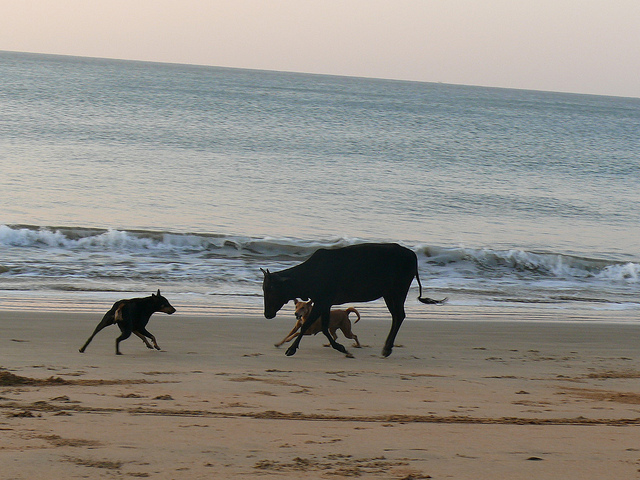

In [12]:
print(train_captions[0])
Image.open(img_name_vector[0])


In [13]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.keras.layers.Resizing(299, 299)(img)
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path


In [14]:
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)


In [15]:
# Get unique images
from tqdm import tqdm
encode_train = sorted(set(img_name_vector))

# Feel free to change batch_size according to your system configuration
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(16)

for img, path in tqdm(image_dataset):
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())

100%|██████████| 375/375 [01:19<00:00,  4.70it/s]


In [16]:
caption_dataset = tf.data.Dataset.from_tensor_slices(train_captions)

# We will override the default standardization of TextVectorization to preserve
# "<>" characters, so we preserve the tokens for the <start> and <end>.
def standardize(inputs):
  inputs = tf.strings.lower(inputs)
  return tf.strings.regex_replace(inputs,
                                  r"!\"#$%&\(\)\*\+.,-/:;=?@\[\\\]^_`{|}~", "")

# Max word count for a caption.
max_length = 50
# Use the top 5000 words for a vocabulary.
vocabulary_size = 5000
tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=vocabulary_size,
    standardize=standardize,
    output_sequence_length=max_length)
# Learn the vocabulary from the caption data.
tokenizer.adapt(caption_dataset)


In [17]:
# Create the tokenized vectors
cap_vector = caption_dataset.map(lambda x: tokenizer(x))

In [18]:
# Create mappings for words to indices and indices to words.
word_to_index = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary())
index_to_word = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary(),
    invert=True)

In [19]:
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(img_name_vector, cap_vector):
  img_to_cap_vector[img].append(cap)

# Create training and validation sets using an 80-20 split randomly.
img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

slice_index = int(len(img_keys)*0.8)
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]

img_name_train = []
cap_train = []
for imgt in img_name_train_keys:
  capt_len = len(img_to_cap_vector[imgt])
  img_name_train.extend([imgt] * capt_len)
  cap_train.extend(img_to_cap_vector[imgt])

img_name_val = []
cap_val = []
for imgv in img_name_val_keys:
  capv_len = len(img_to_cap_vector[imgv])
  img_name_val.extend([imgv] * capv_len)
  cap_val.extend(img_to_cap_vector[imgv])


In [20]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)


(24012, 24012, 6005, 6005)

In [21]:
# Feel free to change these parameters according to your system's configuration

BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
num_steps = len(img_name_train) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64

In [22]:
# Load the numpy files
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

In [23]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int64]),
          num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)


In [24]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # attention_hidden_layer shape == (batch_size, 64, units)
    attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                         self.W2(hidden_with_time_axis)))

    # score shape == (batch_size, 64, 1)
    # This gives you an unnormalized score for each image feature.
    score = self.V(attention_hidden_layer)

    # attention_weights shape == (batch_size, 64, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights


In [25]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x


In [26]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [27]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, tokenizer.vocabulary_size())


In [28]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')


def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)


In [29]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)


In [30]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)


In [31]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

In [32]:
@tf.function
def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([word_to_index('<start>')] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [33]:
EPOCHS = 20

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            average_batch_loss = batch_loss.numpy()/int(target.shape[1])
            print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
      ckpt_manager.save()

    print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')


Epoch 4 Batch 0 Loss 2.1988
Epoch 4 Batch 100 Loss 1.0390
Epoch 4 Batch 200 Loss 0.9463
Epoch 4 Batch 300 Loss 0.8250
Epoch 4 Loss 0.956342
Time taken for 1 epoch 240.97 sec

Epoch 5 Batch 0 Loss 0.8155
Epoch 5 Batch 100 Loss 0.7840
Epoch 5 Batch 200 Loss 0.7063
Epoch 5 Batch 300 Loss 0.7129
Epoch 5 Loss 0.738013
Time taken for 1 epoch 137.78 sec

Epoch 6 Batch 0 Loss 0.6746
Epoch 6 Batch 100 Loss 0.7088
Epoch 6 Batch 200 Loss 0.6367
Epoch 6 Batch 300 Loss 0.6370
Epoch 6 Loss 0.659227
Time taken for 1 epoch 140.43 sec

Epoch 7 Batch 0 Loss 0.6194
Epoch 7 Batch 100 Loss 0.5686
Epoch 7 Batch 200 Loss 0.5834
Epoch 7 Batch 300 Loss 0.5950
Epoch 7 Loss 0.603194
Time taken for 1 epoch 141.84 sec

Epoch 8 Batch 0 Loss 0.5474
Epoch 8 Batch 100 Loss 0.5341
Epoch 8 Batch 200 Loss 0.5560
Epoch 8 Batch 300 Loss 0.5225
Epoch 8 Loss 0.557521
Time taken for 1 epoch 140.57 sec

Epoch 9 Batch 0 Loss 0.5406
Epoch 9 Batch 100 Loss 0.4845
Epoch 9 Batch 200 Loss 0.4862
Epoch 9 Batch 300 Loss 0.5082
Epoch 9

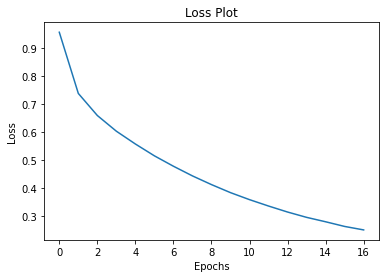

In [34]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()